# ISM reconstruction from BrightEyes-TTM time-tag data

In this notebooks I outline how you can use *MIPLIB* library functions to reconstruct 4D array detector data (*xytc*).

In [4]:
%pylab inline

import h5py
import os
import numpy as np
import time
import signal
import sys
import tqdm  #This package is usefull for have nice progress bar
from scipy.optimize import curve_fit

import datetime
import matplotlib.gridspec as gridspec
import subprocess
import pandas as pd
import numpy as np
from matplotlib.colors import LogNorm
from matplotlib import pyplot as plt



from miplib.ui.plots import image as implots
from miplib.data.adapters import array_detector_data as adapters
#from miplib.data.containers.array_detector_data import ArrayDetectorData

import miplib.ui.cli.miplib_entry_point_options as options
import miplib.processing.ism.reconstruction as ismrec
import miplib.processing.ism.helpers as ismhelps
from miplib.ui.plots import scatter
from miplib.processing import itk as itkutils

Populating the interactive namespace from numpy and matplotlib


# Imported Data Settings

In [22]:
# Phasor Plot - specify the harmonic to work with
h=1                     # Harmonic definition (in this case 1st harmonics calculation)
pixel_dwell_time = 250  # pixel dwell time in microsceconds
remove_border_px = 6    # during the phasor calculation exclude the external border of the image (to remove it set to 0)
central_channel = 10    # 

# 4D file selection
Load 4D data x-y-t-ch for ISM analysis

In [23]:
filename = "/YOURPATH/YOURFILE.h5"

In [24]:
data_filename=os.path.basename(filename).replace(".h5","")
data = h5py.File(filename, 'r+')

Re-arranging the dataset

In [25]:
try:
    dataset = data['dataset_1']
except:
    dataset = data['image_4d']
pixel_number = dataset.shape[0]     # number of pixels in the image
nbins = dataset.shape[2]            # number of bins in the TCSPC histogram
CHANNELS = dataset.shape[3]            # number of bins in the TCSPC histogram

spacing = (1, CHANNELS/pixel_number, CHANNELS/pixel_number)
dataset.attrs["spacing"] = spacing
dataset.shape

(512, 512, 260, 25)

In [26]:
# Central element Phasor plot RAW Dataset
central_element_raw = dataset[:,:,:,central_channel] #12 identify the central element of the array
central_element_raw_image = np.sum(central_element_raw, axis=2)


p=linspace(0,nbins-1,nbins)
cosine=np.cos(2*np.pi*p*h/nbins)
sine=np.sin(2*np.pi*p*h/nbins)

cosine_matrix = np.tile(cosine,(pixel_number,pixel_number,1))
sine_matrix = np.tile(sine,(pixel_number,pixel_number,1))


A=central_element_raw*cosine_matrix
g_central_element_raw=np.sum(A, axis=2)

B=central_element_raw*sine_matrix
s_central_element_raw=np.sum(B, axis=2)

Text(69.54000000000002, 0.5, 'Pixels')

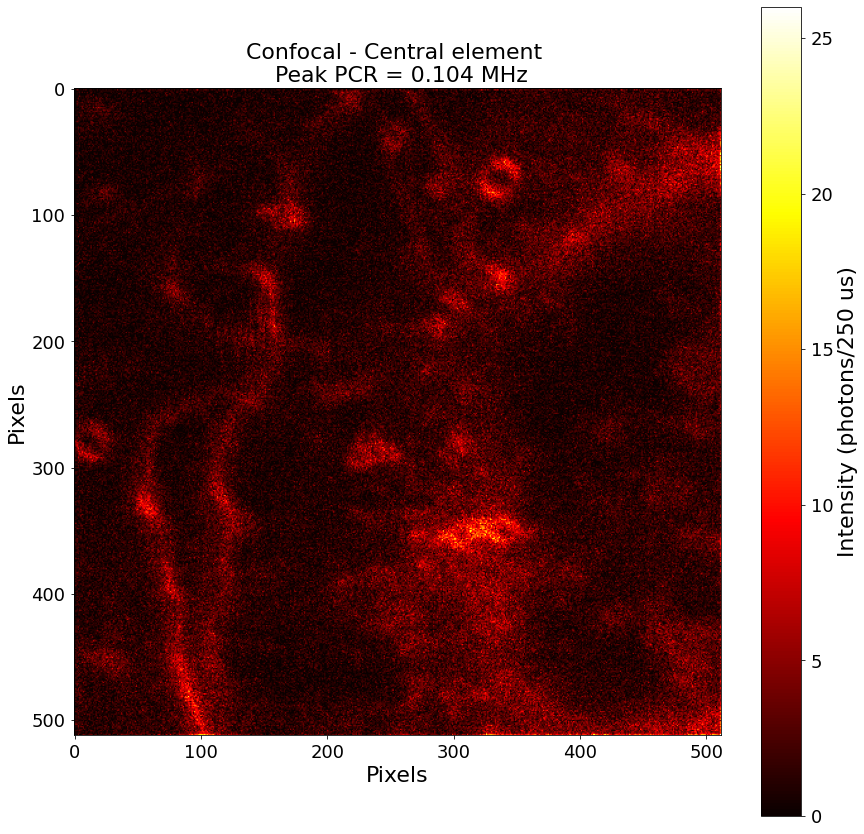

In [27]:
#Plotting central element image
fig= plt.figure(figsize=(12,12))
plt.imshow(central_element_raw_image, cmap='hot')
fig=plt.gcf()
tight_layout()

cbar=plt.colorbar()
cbar.ax.set_ylabel('Intensity (photons/'+str(pixel_dwell_time)+' us)')
plt.title('Confocal - Central element \n Peak PCR = '+str(central_element_raw_image[0:pixel_number,0:pixel_number].max()/pixel_dwell_time)+' MHz')
plt.xlabel('Pixels')
plt.ylabel('Pixels')

#Uncomment for saving the image as vector file
# plt.rcParams['svg.fonttype'] = 'none'
# fig.savefig("Central_Element_"+data_filename+".svg", transparent=True, format='svg', dpi=1200)
# fig.savefig("Central_Element_"+data_filename+".eps", transparent=True, format='eps', dpi=1200)


In [28]:
# Computing the g & s vector for pixel having >5% and >10% of max intensity respectively

threshold_1 = 10 #plotting pixels with intensity >10% of the max
threshold_2 = 5 #plotting pixels with intensity >5% of the max

g_central_element_raw_final = g_central_element_raw[remove_border_px:pixel_number-remove_border_px,remove_border_px:pixel_number-remove_border_px]/central_element_raw_image[remove_border_px:pixel_number-remove_border_px,remove_border_px:pixel_number-remove_border_px]
s_central_element_raw_final = s_central_element_raw[remove_border_px:pixel_number-remove_border_px,remove_border_px:pixel_number-remove_border_px]/central_element_raw_image[remove_border_px:pixel_number-remove_border_px,remove_border_px:pixel_number-remove_border_px]

# Specify a threshold for the minimum amout of photons per pixel to analyze

central_threshold_10percent =floor(threshold_1*(central_element_raw_image[remove_border_px:pixel_number-remove_border_px,remove_border_px:pixel_number-remove_border_px].max()/100))
central_threshold_5percent = floor(threshold_2*(central_element_raw_image[remove_border_px:pixel_number-remove_border_px,remove_border_px:pixel_number-remove_border_px].max()/100))

central_10percent=central_element_raw_image[remove_border_px:pixel_number-remove_border_px,remove_border_px:pixel_number-remove_border_px]>central_threshold_10percent
central_5percent=central_element_raw_image[remove_border_px:pixel_number-remove_border_px,remove_border_px:pixel_number-remove_border_px]>central_threshold_5percent

s_final_10percent = s_central_element_raw_final*central_10percent
g_final_10percent = g_central_element_raw_final*central_10percent

s_final_5percent = s_central_element_raw_final*central_5percent
g_final_5percent = g_central_element_raw_final*central_5percent

g_where_are_NaNs_10percent = np.isnan(g_final_10percent)
s_where_are_NaNs_10percent = np.isnan(s_final_10percent)

g_where_are_NaNs_5percent = np.isnan(g_final_5percent)
s_where_are_NaNs_5percent = np.isnan(s_final_5percent)

g_final_nan_10percent=g_final_10percent[g_where_are_NaNs_10percent==False]
s_final_nan_10percent=s_final_10percent[s_where_are_NaNs_10percent==False]

g_final_nan_5percent=g_final_5percent[g_where_are_NaNs_5percent==False]
s_final_nan_5percent=s_final_5percent[s_where_are_NaNs_5percent==False]

/tmp/ipykernel_620512/538887157.py:6: RuntimeWarning: invalid value encountered in true_divide
  g_central_element_raw_final = g_central_element_raw[remove_border_px:pixel_number-remove_border_px,remove_border_px:pixel_number-remove_border_px]/central_element_raw_image[remove_border_px:pixel_number-remove_border_px,remove_border_px:pixel_number-remove_border_px]
/tmp/ipykernel_620512/538887157.py:7: RuntimeWarning: invalid value encountered in true_divide
  s_central_element_raw_final = s_central_element_raw[remove_border_px:pixel_number-remove_border_px,remove_border_px:pixel_number-remove_border_px]/central_element_raw_image[remove_border_px:pixel_number-remove_border_px,remove_border_px:pixel_number-remove_border_px]


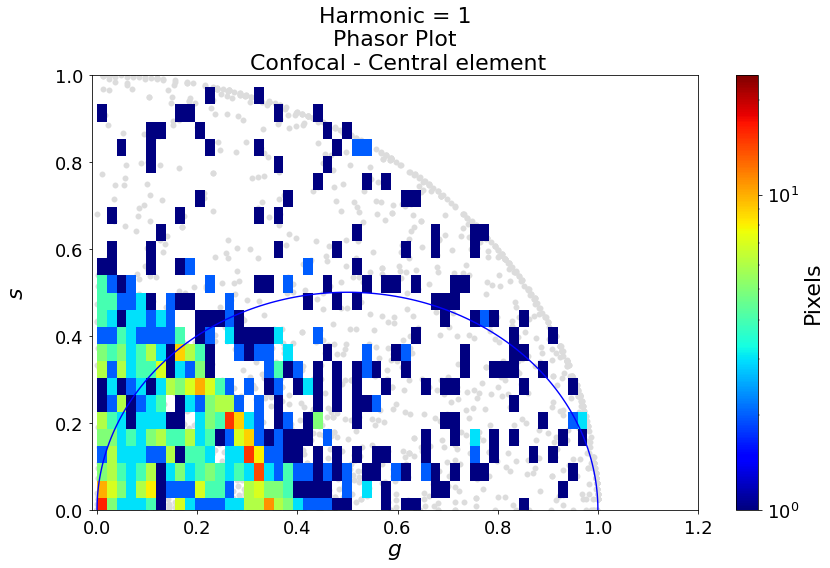

In [29]:
fig= plt.figure(figsize=(12,8))
plt.scatter(g_final_nan_5percent[g_final_nan_5percent>0], s_final_nan_5percent[g_final_nan_5percent>0],c='gainsboro',alpha=1,rasterized=True)
plt.hist2d(g_final_nan_10percent[g_final_nan_10percent>0], s_final_nan_10percent[g_final_nan_10percent>0], bins=50, cmap = 'jet',norm=LogNorm())

cbar=plt.colorbar()
cbar.ax.set_ylabel('Pixels')
plt.title('Harmonic = '+str(h)+'\n Phasor Plot \n Confocal - Central element')
plt.xlabel('$g$')
plt.ylabel('$s$\n')
xx=np.linspace(-2,2,400)
yy=np.linspace(-2,2,400)
[X,Y]=np.meshgrid(xx,yy)

plt.xlim((-0.01,1.2))   # set the xlim to left, right
plt.ylim((0, 1))     # set the xlim to left, right

Z=X**2-X+Y**2
plt.contour(X,Y,Z,[0],colors='b')

fig=plt.gcf()
tight_layout()

#Uncomment for saving the image as vector file
# plt.rcParams['svg.fonttype'] = 'none'
# fig.savefig("Central_Element_PhasorPlot"+data_filename+".svg", transparent=True, format='svg', dpi=1200)
#fig.savefig("Central_Element_PhasorPlot"+data_filename+".eps", transparent=True, format='eps', dpi=1200)


Text(69.54000000000002, 0.5, 'Pixels')

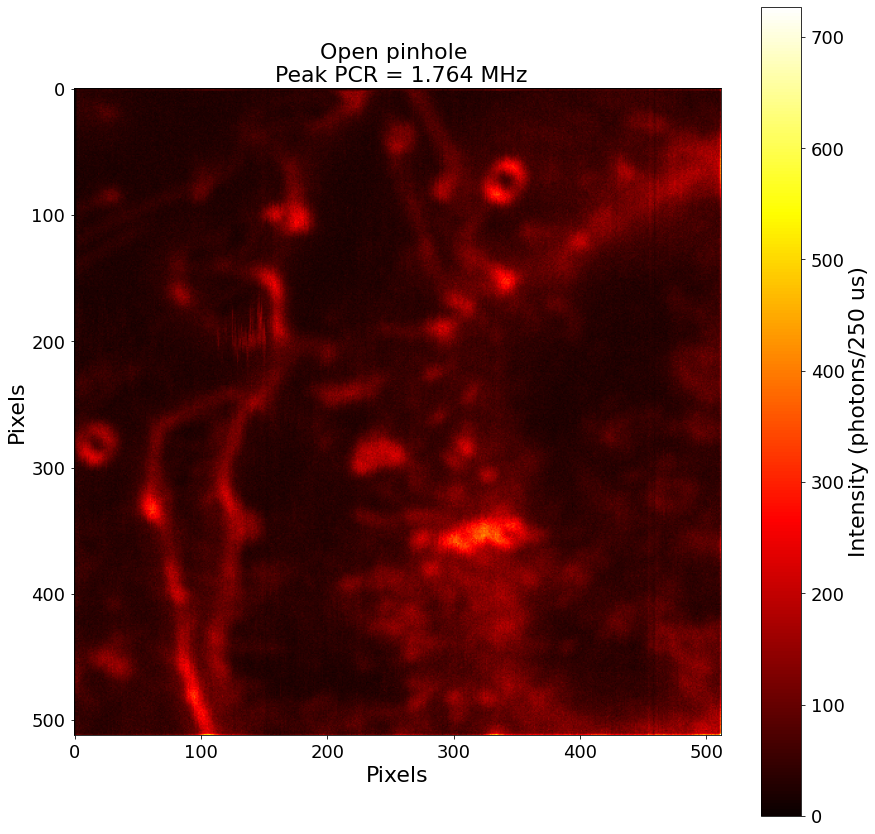

In [30]:
all_elements_raw = np.sum(dataset, axis=3)
all_elements_raw_image = np.sum(all_elements_raw, axis=2)
fig= plt.figure(figsize=(12,12))
plt.imshow(all_elements_raw_image, cmap='hot')
fig=plt.gcf()
tight_layout()

cbar=plt.colorbar()
cbar.ax.set_ylabel('Intensity (photons/'+str(pixel_dwell_time)+' us)')
plt.title('Open pinhole \n Peak PCR = '+str(all_elements_raw_image[0:511,0:511].max()/pixel_dwell_time)+' MHz')
plt.xlabel('Pixels')
plt.ylabel('Pixels')

# Uncomment to save images in vector format
# plt.rcParams['svg.fonttype'] = 'none'
# fig.savefig("SUM_"+data_filename+".svg", transparent=True, format='svg', dpi=1200)
# fig.savefig("SUM_"+data_filename+".eps", transparent=True, format='eps', dpi=1200)

In [31]:
# All elements Phasor plot RAW Dataset
all_elements_raw = np.sum(dataset, axis=3)
all_elements_raw_image = np.sum(all_elements_raw, axis=2)


g_all_elements_raw=np.zeros((pixel_number,pixel_number))
s_all_elements_raw=np.zeros((pixel_number,pixel_number))

A=all_elements_raw*cosine_matrix
g_all_elements_raw=np.sum(A, axis=2)

B=all_elements_raw*sine_matrix
s_all_elements_raw=np.sum(B, axis=2)

In [33]:
# Computing the g & s vector for pixel having >5% and >10% of max intensity respectively

threshold_1 = 10 #plotting pixels with intensity >10% of the max
threshold_2 = 5 #plotting pixels with intensity >5% of the max


g_all_elements_raw_final = g_all_elements_raw[remove_border_px:pixel_number-remove_border_px,remove_border_px:pixel_number-remove_border_px]/all_elements_raw_image[remove_border_px:pixel_number-remove_border_px,remove_border_px:pixel_number-remove_border_px]
s_all_elements_raw_final = s_all_elements_raw[remove_border_px:pixel_number-remove_border_px,remove_border_px:pixel_number-remove_border_px]/all_elements_raw_image[remove_border_px:pixel_number-remove_border_px,remove_border_px:pixel_number-remove_border_px]

# Specify a threshold for the minimum amout of photons per pixel to analyze

sum_threshold_10percent = floor(threshold_1*(all_elements_raw_image[remove_border_px:pixel_number-remove_border_px,remove_border_px:pixel_number-remove_border_px].max()/100))
sum_threshold_5percent = floor(threshold_2*(all_elements_raw_image[remove_border_px:pixel_number-remove_border_px,remove_border_px:pixel_number-remove_border_px].max()/100))

sum_10percent=all_elements_raw_image[remove_border_px:pixel_number-remove_border_px,remove_border_px:pixel_number-remove_border_px]>sum_threshold_10percent
sum_5percent=all_elements_raw_image[remove_border_px:pixel_number-remove_border_px,remove_border_px:pixel_number-remove_border_px]>sum_threshold_5percent

s_final_10percent = s_all_elements_raw_final*sum_10percent
g_final_10percent = g_all_elements_raw_final*sum_10percent

s_final_5percent = s_all_elements_raw_final*sum_5percent
g_final_5percent = g_all_elements_raw_final*sum_5percent

g_where_are_NaNs_10percent = np.isnan(g_final_10percent)
s_where_are_NaNs_10percent = np.isnan(s_final_10percent)

g_where_are_NaNs_5percent = np.isnan(g_final_5percent)
s_where_are_NaNs_5percent = np.isnan(s_final_5percent)

g_final_nan_10percent=g_final_10percent[g_where_are_NaNs_10percent==False]
s_final_nan_10percent=s_final_10percent[s_where_are_NaNs_10percent==False]

g_final_nan_5percent=g_final_5percent[g_where_are_NaNs_5percent==False]
s_final_nan_5percent=s_final_5percent[s_where_are_NaNs_5percent==False]

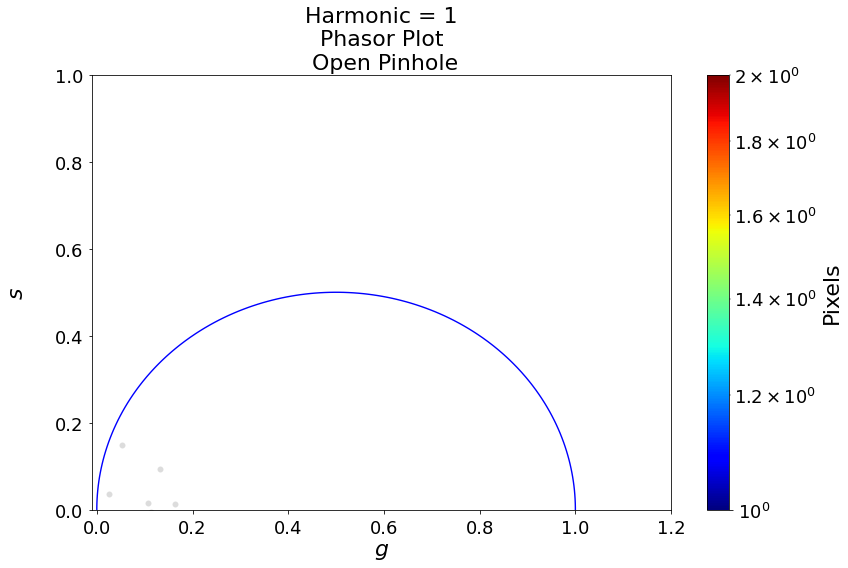

In [34]:
fig= plt.figure(figsize=(12,8))
plt.scatter(g_final_nan_5percent[g_final_nan_5percent>0], s_final_nan_5percent[g_final_nan_5percent>0],c='gainsboro',alpha=1,rasterized=True)
plt.hist2d(g_final_nan_10percent[g_final_nan_10percent>0], s_final_nan_10percent[g_final_nan_10percent>0], bins=50, cmap = 'jet',norm=LogNorm())
cbar=plt.colorbar()
cbar.ax.set_ylabel('Pixels')
plt.title('Harmonic = '+str(h)+'\n Phasor Plot \n Open Pinhole')
plt.xlabel('$g$')
plt.ylabel('$s$\n')
xx=np.linspace(-2,2,400)
yy=np.linspace(-2,2,400)
[X,Y]=np.meshgrid(xx,yy)

plt.xlim((-0.01,1.2))   # set the xlim to left, right
plt.ylim((0, 1))     # set the xlim to left, right

Z=X**2-X+Y**2
plt.contour(X,Y,Z,[0],colors='b')

fig=plt.gcf()
tight_layout()

# plt.rcParams['svg.fonttype'] = 'none'
# fig.savefig("SUM_PhasorPlot_"+data_filename+".svg", transparent=True, format='svg', dpi=1200)
#fig.savefig("SUM_PhasorPlot_"+data_filename+".eps", transparent=True, format='eps', dpi=1200)

For reconstruction purposes it makes more sense to reorder the axes a little bit.

In [43]:
data = np.moveaxis(dataset, (0, 1, 2, 3), (2, 3, 1, 0))
data.shape

(25, 260, 512, 512)

## Calculating the ISM shift vectors

*MIPLIB* uses an internal data structure called *ArrayDetectorData* to contain ISM data and results. Here instead of doing a real conversion, I just wrap an array into an adapter, that makes the data act like an *ArrayDetectorData* object. In order to have the data in a correct shape, I sum over the time bins, and add a new empty axis for a photosensor. We use the photosensor in the *traditional* ISM to split a pixel dwell time into several pieces. It of course has no other purpose in here than having the data in a shape that is compatible with the library functions.  

In [44]:
ad_data_2D = adapters.ArrayAdapter(np.expand_dims(np.sum(data, axis=1), axis=0), 
                                   dataset.attrs["spacing"][1:])

Then it's time to run the registration. There are several parameters that you can tune, but the defaults should be fine in 99.9% of cases. Please adjust the *fixed_idx* to match the index of the central detector. It's normally 12, but 10 here, because the corner pixels are missing. Actually the registration will in principle work with any of the images as reference, but probably not very robustly.

In [45]:
args = ("{} all --sampling-percentage=1 --reg-relax-factor=.7 --learning-rate=.7 --min-step=0.001 "         
        "--reg-max-iterations=300 --reg-method=correlation --reg-translate-only ".format(os.getcwd())).split()

params = options.get_ism_script_options(args)

offsets, transforms_2D = ismrec.find_image_shifts(ad_data_2D, params, fixed_idx=10)

Below I plot the detected xy offsets. The detector seems to be somewhat misaligned. In any case the ISM should work just fine, as there are clear offsets between the channels.

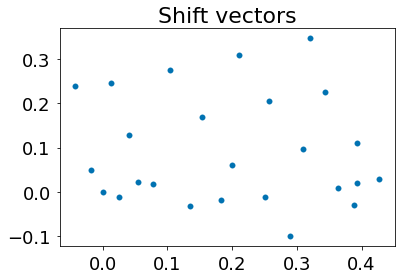

In [46]:
ys = np.transpose(offsets)[0]
xs = np.transpose(offsets)[1]

plt.title('Shift vectors')
plt.scatter(xs,ys)

Just to take a closer look at the alignment situation, below you can see the fingerprint image. Indeed it seems that the PSF is not really in the center of the detector, but rather close to the bottom.

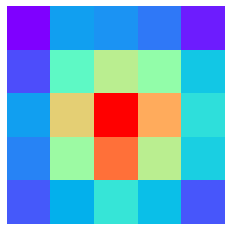

In [51]:
fingerprint = np.sum(data, axis=(1,2,3))
implots.display_2d_image(fingerprint.reshape(5,5))

## ISM pixel reassignment

Now that we have the 2D offsets, we can calculate the ISM results. First I will start with the 2D (time-projected) dataset that was used above, just to make sure that everything works properly. *The result_sum* is in practice the regular confocal with a pinhole matching the detector FOV, and *result_ism* is the reassignment result. Nothing extraordinary here, but the reassignment does increase the image quality clearly. 

In [52]:
result_ism = ismrec.shift_and_sum(ad_data_2D, transforms_2D)
result_sum = ismrec.sum(ad_data_2D)

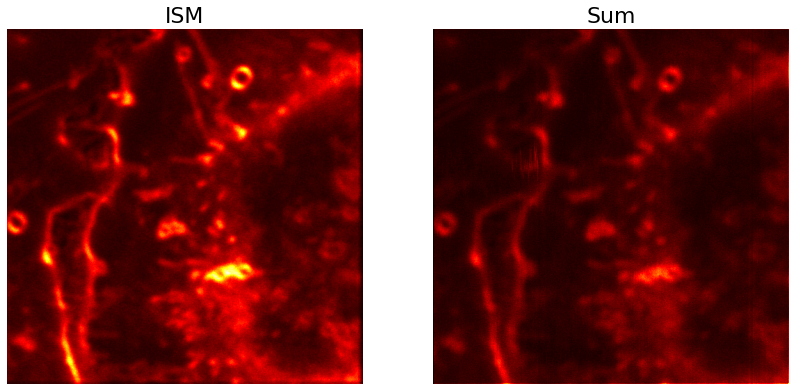

In [53]:
implots.display_2d_images(result_ism, result_sum, image1_title='ISM', image2_title='Sum')

Text(0, 0.5, 'Pixels')

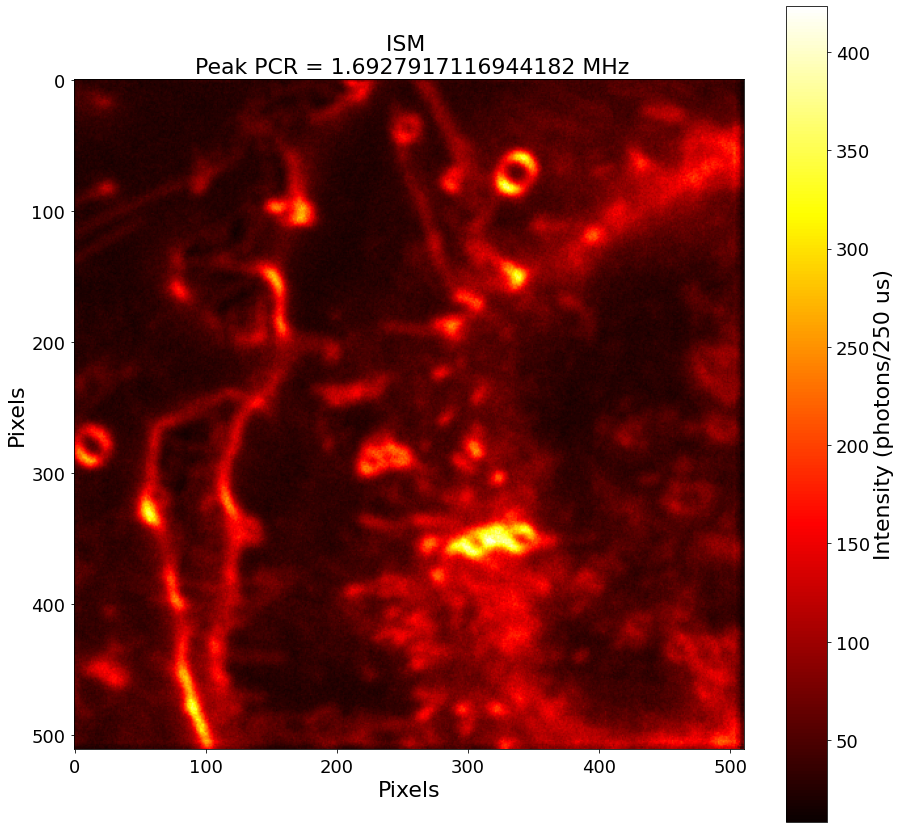

In [54]:
fig= plt.figure(figsize=(15,15))
plt.imshow(result_ism[0:511,0:511], cmap='hot')
cbar=plt.colorbar()
cbar.ax.set_ylabel('Intensity (photons/'+str(pixel_dwell_time)+' us)')
plt.title('ISM \n Peak PCR = '+str(result_ism.max()/pixel_dwell_time)+' MHz')
plt.xlabel('Pixels')
plt.ylabel('Pixels')


In order to process the full dataset, we just basically have to do the same reassignment on each of the time bins. Here in order to speed up things a little bit I construct 3D spatial transforms with z (== time) offset set to zero. That allows me to use 3D resampling functions for the reassignment, which is quite a bit faster than looping over the time bins one-by-one. Please note that I use exatly the same library functions as above.

In [55]:
offsets_3d = np.transpose(np.vstack((xs, ys, np.zeros_like(xs))))
transforms_3d = itkutils.make_translation_transforms_from_offsets(offsets_3d)

ad_data = adapters.ArrayAdapter(np.expand_dims(data, axis=0), dataset.attrs["spacing"])

In [56]:
result_ism_3d = ismrec.shift_and_sum(ad_data, transforms_3d)
result_ism_3d_tproject = np.sum(result_ism_3d, axis=0)


Here I compare the two ISM results: one obtained by summing of time first and then calculating the reassignment, and the other by doing the reassignment first and then summing over time. Of course the difference is that the 3D result, maintains the time information, so you can do lifetime fitting etc if you like.

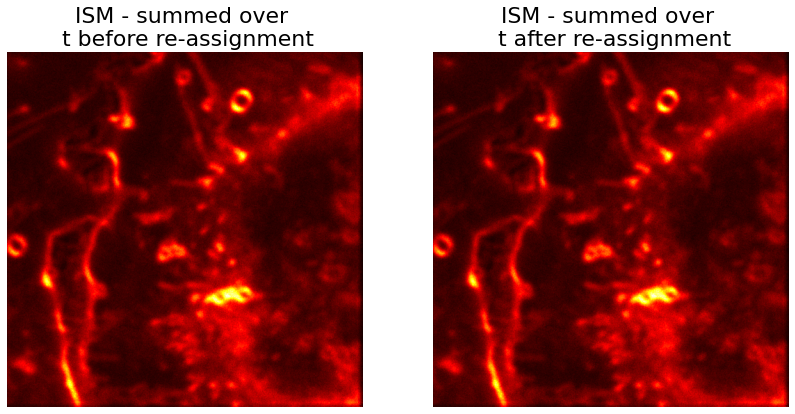

In [57]:
implots.display_2d_images(result_ism, result_ism_3d_tproject, 
                          image1_title='ISM - summed over \n t before re-assignment', 
                          image2_title='ISM - summed over \n t after re-assignment')

Just to make sure that alls is as it should, here's the difference between the above two images. The noise distribution seems to be a bit different, but that is to be expected.  

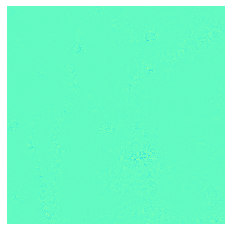

In [58]:
implots.display_2d_image(result_ism_3d_tproject-result_ism)

Just to make sure, to conclude, here I plot the time trace thorugh the stack (all pixels summed). Seems to be fine.

In [59]:
shifted_sum_3d = ismrec.shift_and_sum(ad_data, transforms_3d) 

KeyboardInterrupt: 

In [ ]:
shifted_sum_3d_dataset_image=np.sum(shifted_sum_3d, axis=(0))

In [ ]:
fig= plt.figure(figsize=(12,12))
plt.imshow(shifted_sum_3d_dataset_image[0:511,0:511], cmap='hot')
fig=plt.gcf()
tight_layout()

cbar=plt.colorbar()
cbar.ax.set_ylabel('Intensity (photons/'+str(pixel_dwell_time)+' us)')
plt.title('ISM \n Peak PCR = '+str(result_ism.max()/pixel_dwell_time)+' MHz')
plt.xlabel('Pixels')
plt.ylabel('Pixels')

# Uncomment to save vector image
# plt.rcParams['svg.fonttype'] = 'none'
# fig.savefig("ISM_"+data_filename+".svg", transparent=True, format='svg', dpi=1200)
# fig.savefig("ISM_"+data_filename+".eps", transparent=True, format='eps', dpi=1200)

In [ ]:
# Phasor plot calculation for ISM data

p=linspace(0,nbins-1,nbins)
cosine=np.cos(2*np.pi*p*h/nbins)
sine=np.sin(2*np.pi*p*h/nbins)

cosine_matrix = np.tile(cosine,(pixel_number,pixel_number,1))
cosine_matrix.shape

sine_matrix = np.tile(sine,(pixel_number,pixel_number,1))

cosine_matrix_sw=np.swapaxes(np.swapaxes(cosine_matrix,0,2),1,2)
sine_matrix_sw=np.swapaxes(np.swapaxes(sine_matrix,0,2),1,2)

A=shifted_sum_3d*cosine_matrix_sw
g=np.sum(A, axis=0)

B=shifted_sum_3d*sine_matrix_sw
s=np.sum(B, axis=0)




In [ ]:
# Computing the g & s vector for pixel having >5% and >10% of max intensity respectively

threshold_1 = 10 #plotting pixels with intensity >10% of the max
threshold_2 = 5 #plotting pixels with intensity >5% of the max

g_final = g[remove_border_px:pixel_number-remove_border_px,remove_border_px:pixel_number-remove_border_px]/shifted_sum_3d_dataset_image[remove_border_px:pixel_number-remove_border_px,remove_border_px:pixel_number-remove_border_px]
s_final = s[remove_border_px:pixel_number-remove_border_px,remove_border_px:pixel_number-remove_border_px]/shifted_sum_3d_dataset_image[remove_border_px:pixel_number-remove_border_px,remove_border_px:pixel_number-remove_border_px]

# Specify a threshold for the minimum amout of photons per pixel to analyze

sum_shift_threshold_10percent = floor(threshold_1*(shifted_sum_3d_dataset_image[remove_border_px:pixel_number-remove_border_px,remove_border_px:pixel_number-remove_border_px].max()/100))
sum_shift_threshold_5percent = floor(threshold_2*(shifted_sum_3d_dataset_image[remove_border_px:pixel_number-remove_border_px,remove_border_px:pixel_number-remove_border_px].max()/100))

mask_sum_shift_10percent=shifted_sum_3d_dataset_image[remove_border_px:pixel_number-remove_border_px,remove_border_px:pixel_number-remove_border_px]>sum_shift_threshold_10percent
mask_sum_shift_5percent=shifted_sum_3d_dataset_image[remove_border_px:pixel_number-remove_border_px,remove_border_px:pixel_number-remove_border_px]>sum_shift_threshold_5percent

s_final_10percent = s_final*mask_sum_shift_10percent
g_final_10percent = g_final*mask_sum_shift_10percent

s_final_5percent = s_final*mask_sum_shift_5percent
g_final_5percent = g_final*mask_sum_shift_5percent

g_where_are_NaNs_10percent = np.isnan(g_final_10percent)
s_where_are_NaNs_10percent = np.isnan(s_final_10percent)

g_where_are_NaNs_5percent = np.isnan(g_final_5percent)
s_where_are_NaNs_5percent = np.isnan(s_final_5percent)

g_final_nan_10percent=g_final_10percent[g_where_are_NaNs_10percent==False]
s_final_nan_10percent=s_final_10percent[s_where_are_NaNs_10percent==False]

g_final_nan_5percent=g_final_5percent[g_where_are_NaNs_5percent==False]
s_final_nan_5percent=s_final_5percent[s_where_are_NaNs_5percent==False]


In [ ]:

fig= plt.figure(figsize=(12,8))
plt.scatter(g_final_nan_5percent[g_final_nan_5percent>0], s_final_nan_5percent[g_final_nan_5percent>0],c='gainsboro',alpha=1,rasterized=True)
plt.hist2d(g_final_nan_10percent[g_final_nan_10percent>0], s_final_nan_10percent[g_final_nan_10percent>0], bins=50, cmap = 'jet',norm=LogNorm())
cbar=plt.colorbar()
cbar.ax.set_ylabel('Pixels')
plt.title('Harmonic = '+str(h)+'\n Phasor Plot \n ISM')
plt.xlabel('$g$')
plt.ylabel('$s$\n')
xx=np.linspace(-2,2,400)
yy=np.linspace(-2,2,400)
[X,Y]=np.meshgrid(xx,yy)

plt.xlim((-0.01,1.2))   # set the xlim to left, right
plt.ylim((0, 1))     # set the xlim to left, right

Z=X**2-X+Y**2
plt.contour(X,Y,Z,[0],colors='b')
fig=plt.gcf()
tight_layout()

# Uncomment for saving vector image
# plt.rcParams['svg.fonttype'] = 'none'
# fig.savefig("ISM_Phasor_Plot_"+data_filename+".svg", transparent=True, format='svg', dpi=1200)
#fig.savefig("ISM_Phasor_Plot"+data_filename+".eps", transparent=True, format='eps', dpi=1200)

# Data export

In [ ]:
#Data export


#Save ISM data in a 3D file with txy
import h5py
h5f = h5py.File('ISM'+data_filename,'w')
h5f.create_dataset('3dISM', data=shifted_sum_3d)
h5f.close()


#Save Confocal_Open_ISM images in h5 with 3 datasets
import h5py
h5f = h5py.File('Confocal_Open_ISM'+data_filename,'w')
h5f.create_dataset('Confocal', data=central_element_raw_image, dtype='f8')
h5f.create_dataset('Open', data=all_elements_raw_image, dtype='f8')
h5f.create_dataset('ISM', data=shifted_sum_3d_dataset_image, dtype='f8')
h5f.close()


Task was destroyed but it is pending!
task: <Task pending name='Task-2' coro=<Kernel.poll_control_queue() running at /home/mdonato/.local/lib/python3.8/site-packages/ipykernel/kernelbase.py:273> wait_for=<Future finished result=<Future at 0x...state=pending>> cb=[_chain_future.<locals>._call_set_state() at /usr/lib/python3.8/asyncio/futures.py:367]>
